<a href="https://colab.research.google.com/github/Rajeeb321123/Deep-learning-tensorFlow-Journey/blob/master/05_transfer_learning_in_tensorflow_part2_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: Fine Tunning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
!nvidia-smi

Wed Mar  6 12:14:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating hepler function
In previous notebooks, we've created a bunch of hepler functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the function we've used previously here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-06 13:59:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-06 13:59:48 (84.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import hepler functions we're going to use in the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your hepler function.

## Let's get some data

This time we're going to see how we can use pretrained within tf.keras.application and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-03-06 09:36:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   168MB/s    in 1.0s    

2024-03-06 09:36:36 (168 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Check out how many images and subdirectories in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE=32

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # As we are using multi-class dataset
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[7.87142792e+01 7.87142792e+01 5.47142868e+01]
   [7.83316345e+01 7.77346954e+01 5.55255127e+01]
   [7.81428528e+01 7.71428528e+01 5.75714302e+01]
   ...
   [9.30765228e+01 8.35050507e+01 7.32907867e+01]
   [9.60969543e+01 8.20969543e+01 7.30969543e+01]
   [1.01484741e+02 8.44847412e+01 7.64847412e+01]]

  [[8.10204086e+01 7.80255127e+01 5.53571434e+01]
   [7.90000000e+01 7.70000000e+01 5.60000000e+01]
   [7.73724442e+01 7.46020355e+01 5.78724480e+01]
   ...
   [9.55153503e+01 8.31581421e+01 7.39438782e+01]
   [9.78622437e+01 8.38622437e+01 7.48622437e+01]
   [1.00954086e+02 8.39540863e+01 7.59540863e+01]]

  [[8.42193832e+01 7.71428528e+01 5.81428566e+01]
   [8.18571396e+01 7.67142868e+01 5.77857132e+01]
   [7.99081573e+01 7.61887741e+01 6.20000000e+01]
   ...
   [9.95714722e+01 8.59081726e+01 7.47398224e+01]
   [1.01198975e+02 8.71989746e+01 7.61989746e+01]
   [1.01494888e+02 8.51377487e+01 7.53520355e+01]]

  ...

  [[1.19790871e+02 1.16500084e+02 1.09862366e+02]
   [1

## Model 0: Building a transfer learning model using the Keras Functional api

The sequential API is straigh-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [ ]:
# 1. Create the base model using tf.keras.application
# EfficentNetB0 has rescaling built unlike resnetV250 , so we don't need to rescale here
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # as we want our own dense layers at the top with no of output i.e. 10 here

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our models
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) # We can normalize data directly inside the model. Remember we had to do train_datagen = ImageDataGenerator(rescale=1/255.) before puting it into model.

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the model (aggreagate all the most important information, reduce numbers of computaton)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)


shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [ ]:
# 9. Compile the model:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# 10. Fit the model:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),# validate on only 25 % of test data for quicker execution
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent")]
                                 )

Saving TensorBoard log files to: transfer_learning/10_percent/20240306-140627
Epoch 1/5
24/24 [==============================] - 14s 207ms/step - loss: 1.8221 - accuracy: 0.4507 - val_loss: 1.2816 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 5s 179ms/step - loss: 1.0805 - accuracy: 0.7547 - val_loss: 0.8851 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 4s 138ms/step - loss: 0.7783 - accuracy: 0.8347 - val_loss: 0.6980 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 7s 298ms/step - loss: 0.6490 - accuracy: 0.8520 - val_loss: 0.6429 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 5s 190ms/step - loss: 0.5387 - accuracy: 0.8827 - val_loss: 0.5672 - val_accuracy: 0.8520


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 12s 129ms/step - loss: 0.5561 - accuracy: 0.8620


[0.5561497211456299, 0.8619999885559082]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# how about we get summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_pooling_layer (Glob  (None, 1280)              0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


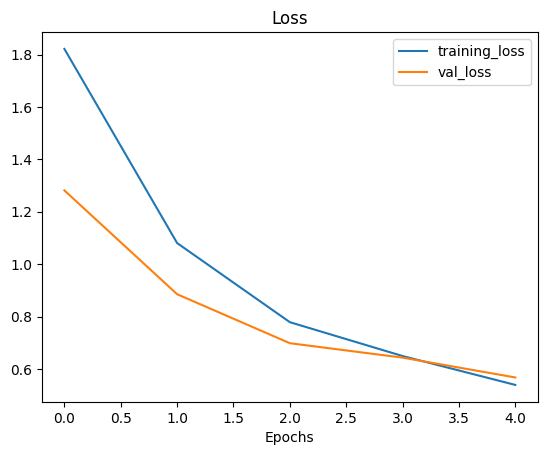

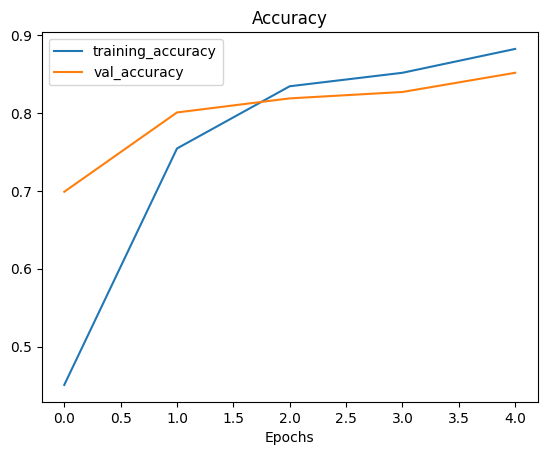

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature model from a trained model

Let's demonstrate the Global Average Pooling 2D layers...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)..

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape =(1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

⚒️ **Practice:** Try to do the same with the two cells but this time uses `GlobalMaxPool2D`... and see what happens.

In [ ]:
# Define the input shape
input_shape =(1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_Maxed_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global max Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global max pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global max Pooled 2D tensor: (1, 3)


🔑 Note: One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a feature vector, a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the  `tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of our own specific problems.

### Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3.`model_3` - use fine-tunning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of trhe training data with data augmentaion.

🔑Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for the model_1

In [ ]:
# Download and unzip data - preprocessed from Food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2024-03-06 12:14:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.207, 173.194.198.207, 142.251.172.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   186MB/s    in 0.7s    

2024-03-06 12:14:55 (186 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [ ]:
import tensorflow as tf

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top our heads, after reading the docs, the benefits of using data augmentaion inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster than CPU like in previous old ImageDataGenerator which donont use GPU of augmentaion).
* Image data augmentaion only happen during training, so we can still export our whole model and use it elsewhere.
* While passing Data augmentaion as a layer to a model data augmentaion is automatically turned on during training (augments training data) but turned off during inference (doesnot augment testing data or new unseen data).

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc.
data_augmentation = keras.Sequential([ # imp. Though we are using Functional API, we can create a model for adding into Functional API
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built in.
], name = "data_augmentation")

### Visualize our data augmentation layer(and see what happens to our data)

10_food_classes_1_percent/train/fried_rice/2980189.jpg


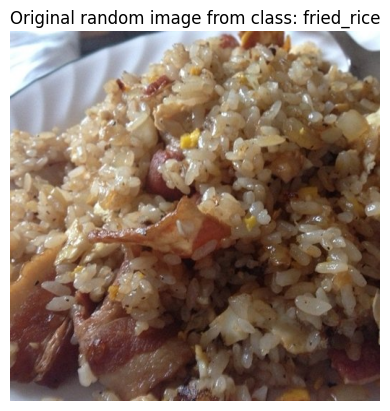

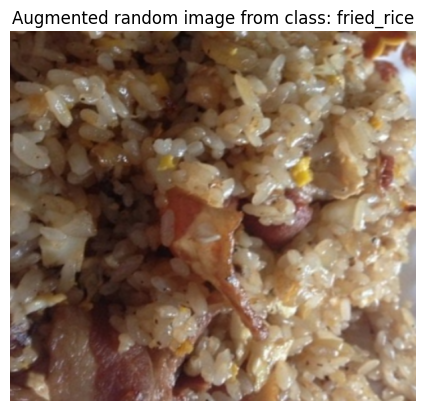

In [ ]:
# View a random image and compare to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow((augmented_img)/255.) # we plt need normalized image values of tensor
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we want to put our own layer on top: meaning at the output
base_model.trainable = False

# Create input layer
inputs = layers.Input( shape = input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer as the output_layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using a input and output
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_1_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 # Track model training logs
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="1_percent_data_aug")]
                                 )

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240306-122522
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.3583 - accuracy: 0.1143 - val_loss: 2.1938 - val_accuracy: 0.2138
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.0728 - accuracy: 0.3143 - val_loss: 2.0704 - val_accuracy: 0.2961
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8648 - accuracy: 0.4857 - val_loss: 1.9662 - val_accuracy: 0.3783
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.7519 - accuracy: 0.4714 - val_loss: 1.8670 - val_accuracy: 0.4507
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5638 - accuracy: 0.6143 - val_loss: 1.7691 - val_accuracy: 0.4868


In [ ]:
# Check out our model_1 summary
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [ ]:
# Evaluate on the full test dataset
results_1_percent_aug = model_1.evaluate(test_data)
results_1_percent_aug

79/79 [==============================] - 7s 73ms/step - loss: 1.7668 - accuracy: 0.4868


[1.7667876482009888, 0.4867999851703644]

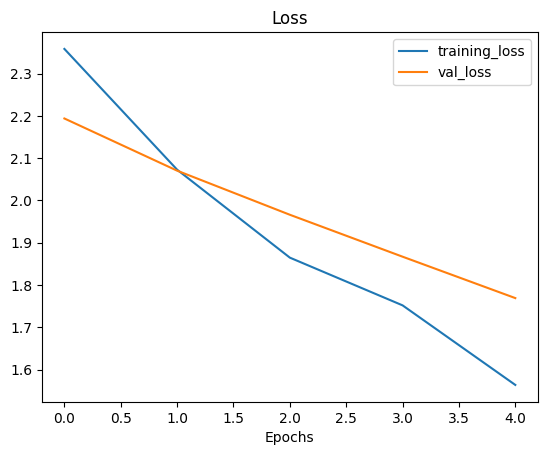

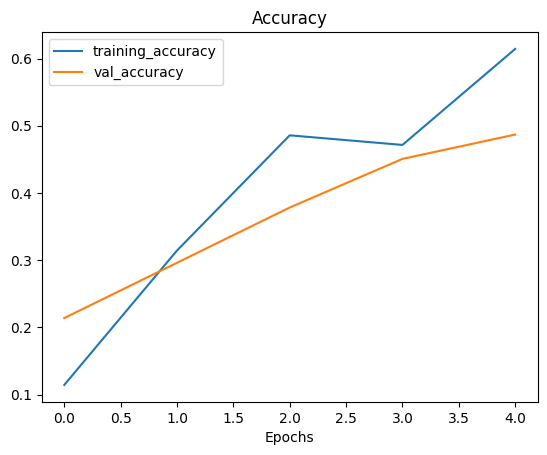

In [ ]:
# How does the model with 1% of the data and datat augmentation? let's look at the loss curves
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentaion

In [ ]:
# Get 10% of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-03-06 14:00:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.9MB/s    in 8.2s    

2024-03-06 14:00:12 (19.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set the data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


In [ ]:
# Build data augmentaion layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/.255) # EfficientB0 has already rescaling built but if we are using resnet50V2 we need to rescale
],name = "data_augmentation")

In [ ]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name = "input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesnot occur on test data, only on training data)

# We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.
x = base_model(x, training=False) # pass augmented images to base model but keeps it in inference mode, this also insures batch-norm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model

x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

### Creating a ModelCheckPoint callback

The ModelCheckPoint callback intermediately saves our model(the full model or just the weight) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves  the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False, # true is good option but if false, checkpoint are overwritten every time
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1
                                                         )

### Fit model_2 passing in the ModelCheckpoint Callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_aug = model_2.fit(train_data_10_percent,
                                     epochs=initial_epochs,
                                     validation_data=test_data,
                                     validation_steps=int(0.25 * len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                            experiment_name="10_percent_data_aug"),
                                     checkpoint_callback]
                                     )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240306-140038
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9538 - accuracy: 0.3733
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 38s 1s/step - loss: 1.9538 - accuracy: 0.3733 - val_loss: 1.3627 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.7120
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 862ms/step - loss: 1.2840 - accuracy: 0.7120 - val_loss: 0.9734 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.7733
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 785ms/step - loss: 0.9963 - accuracy: 0.7733 - val_loss: 0.7714 - val_accuracy: 0.8289
Epoc

In [ ]:
# what were model_0 results?
model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.6114 - accuracy: 0.8440


[0.6114147305488586, 0.843999981880188]

In [ ]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 64ms/step - loss: 0.6114 - accuracy: 0.8440


[0.6114146709442139, 0.843999981880188]

In [ ]:
# what were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5561 - accuracy: 0.8620


[0.5561497211456299, 0.8619999885559082]

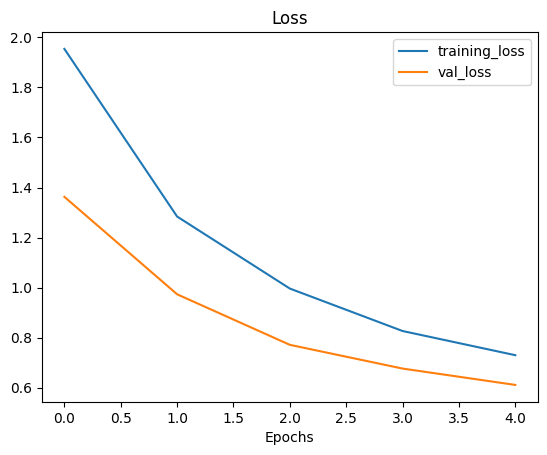

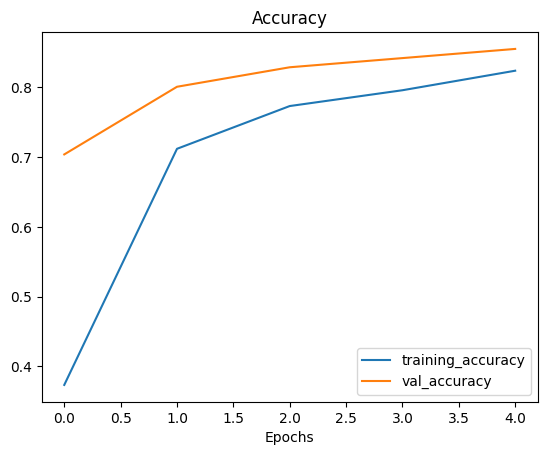

In [ ]:
# Plot the model loss curves
plot_loss_curves(history_10_percent_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 96ms/step - loss: 0.6114 - accuracy: 0.8440


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug

[0.6114146709442139, 0.843999981880188]

In [ ]:
loaded_weights_model_results # look there is slight difference because how computer precision store large number

[0.6114147901535034, 0.843999981880188]

In [ ]:
# Check to see if loaded model results are very close to our previous  non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]
